In [2]:
pip install prettytable

In [3]:
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [4]:
#Initialise Methods

#Resize image
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

#We will use approxPolyDP for approximating more primitive contour shape consisting of as few points as possible
#Approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

#Find 4 points of receipt
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
#Convert 4 points into lines / rect      
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio
#Original receipt with wrapped perspective
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))
#Threshold image
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique


C:\Users\Bekalu\AppData\Local\Temp\ipykernel_16692\3792823380.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


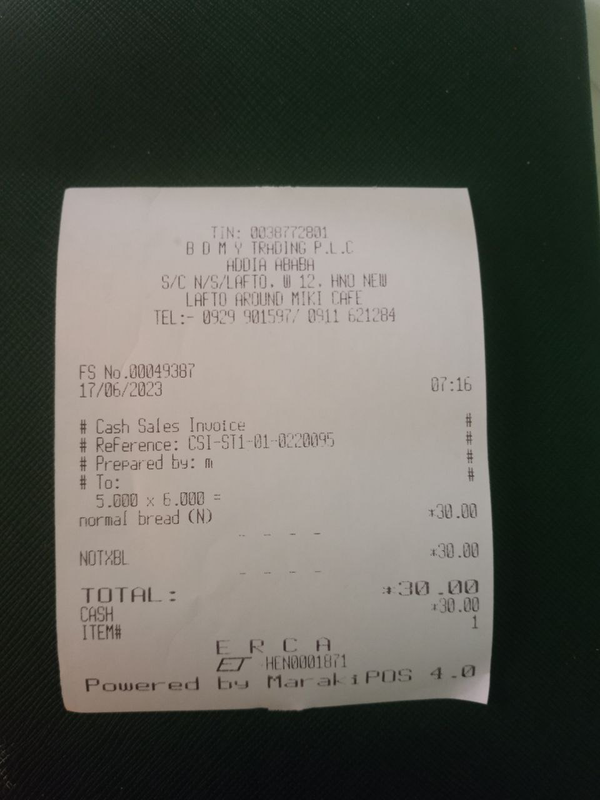

In [5]:
# Sample file out of the dataset
#dummy 01 : image on white background
#dummy 02 : image on gradient backgound
#dummy 03 : random reciept
#dummy 04 : random reciept
#Hits 02 and 09
file_name = "C:\\Users\\Bekalu\\Desktop\\seleda\\bill9.jpg"

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [7]:
image = cv2.imread(file_name)

#Downscale image.
#Finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

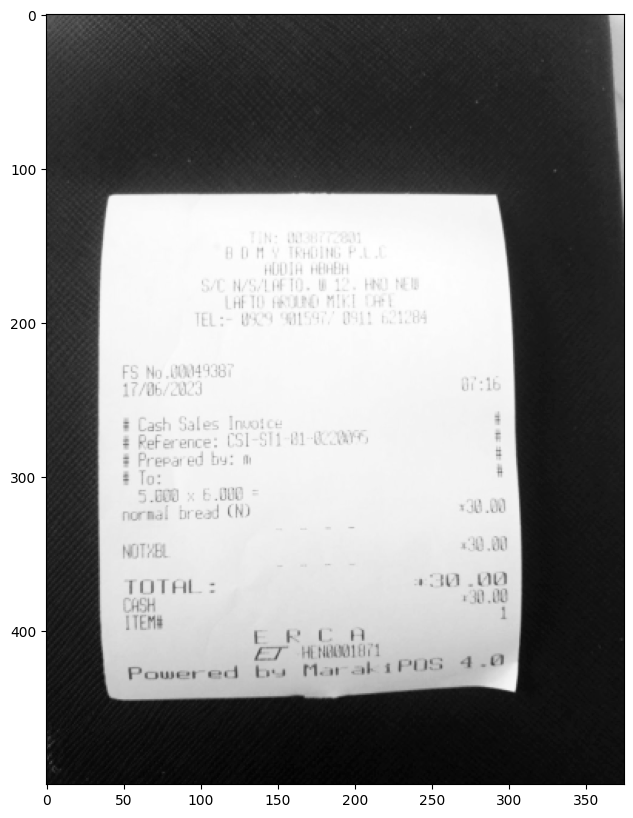

In [8]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

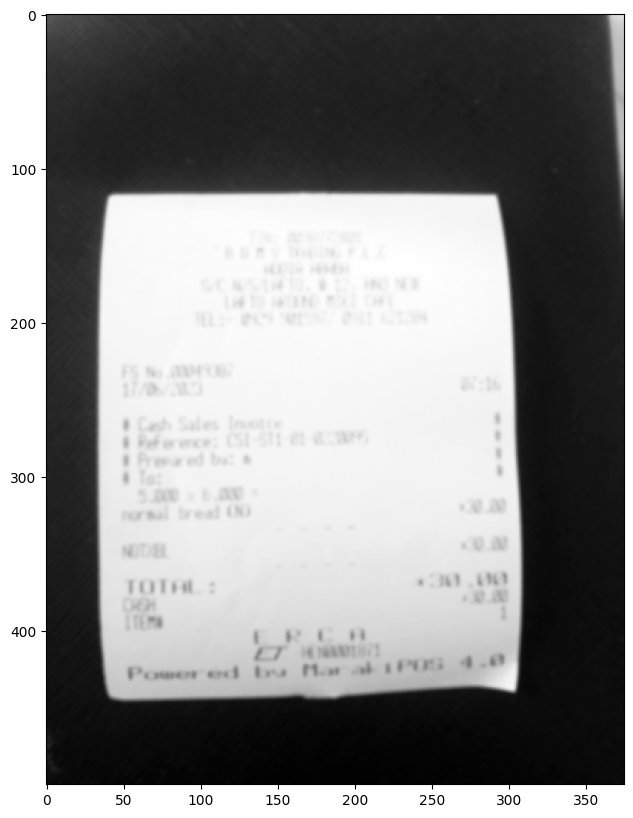

In [9]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

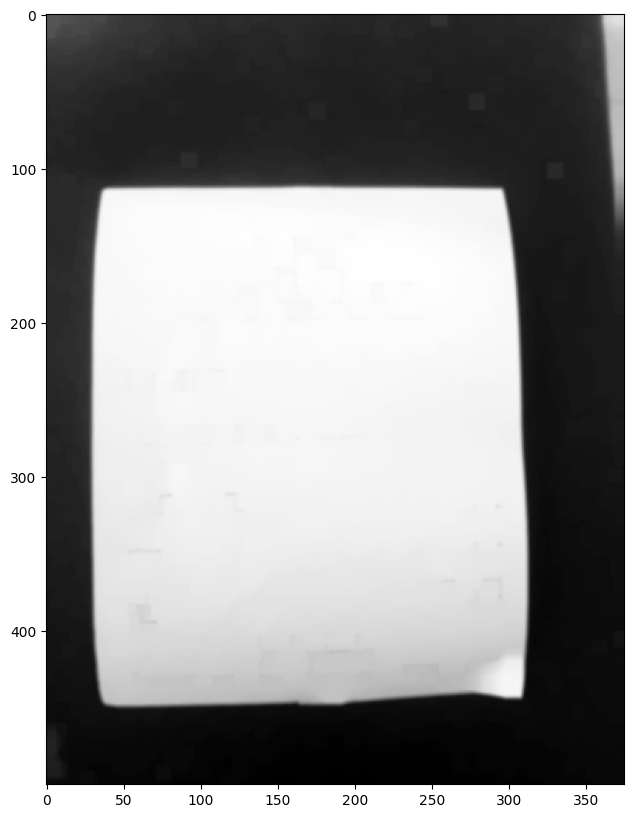

In [10]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)


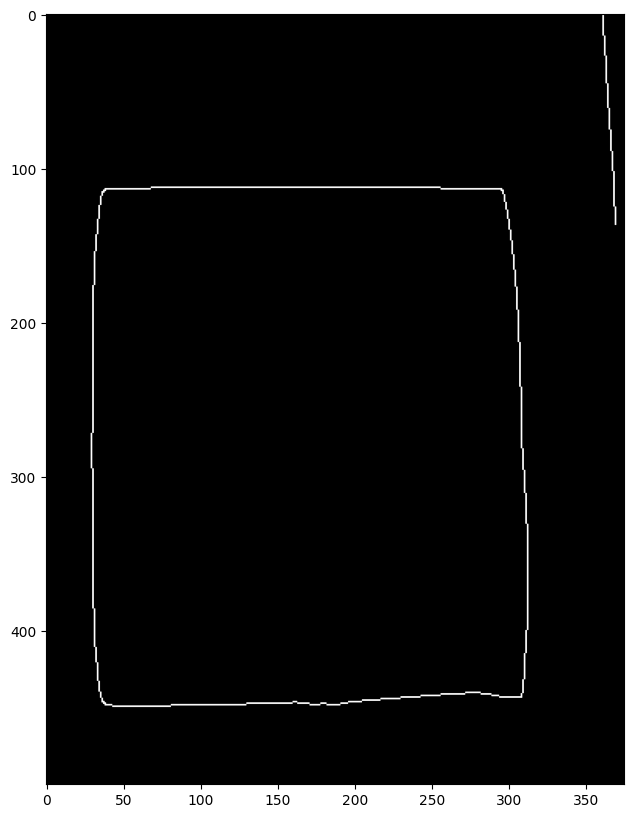

In [11]:
edged = cv2.Canny(dilated, 50, 125, apertureSize=3)
plot_gray(edged)

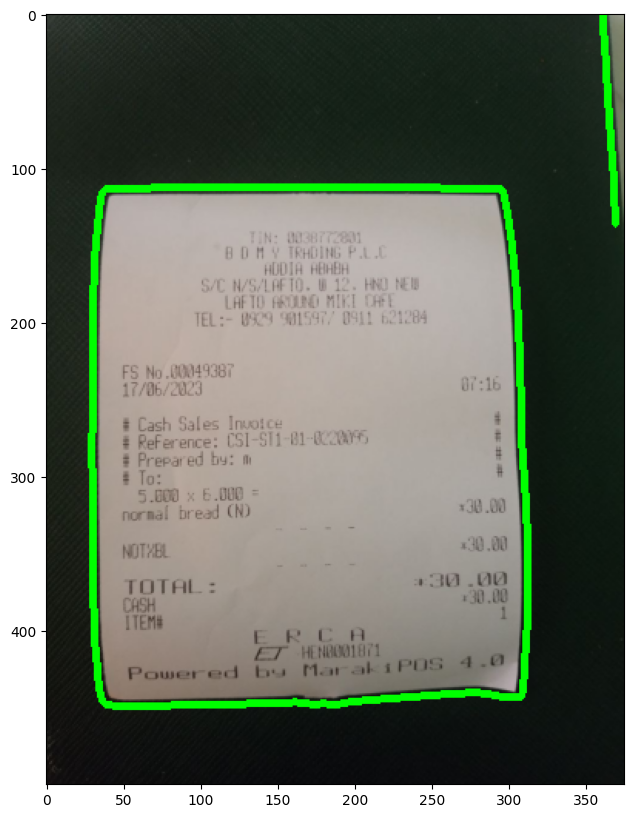

In [12]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

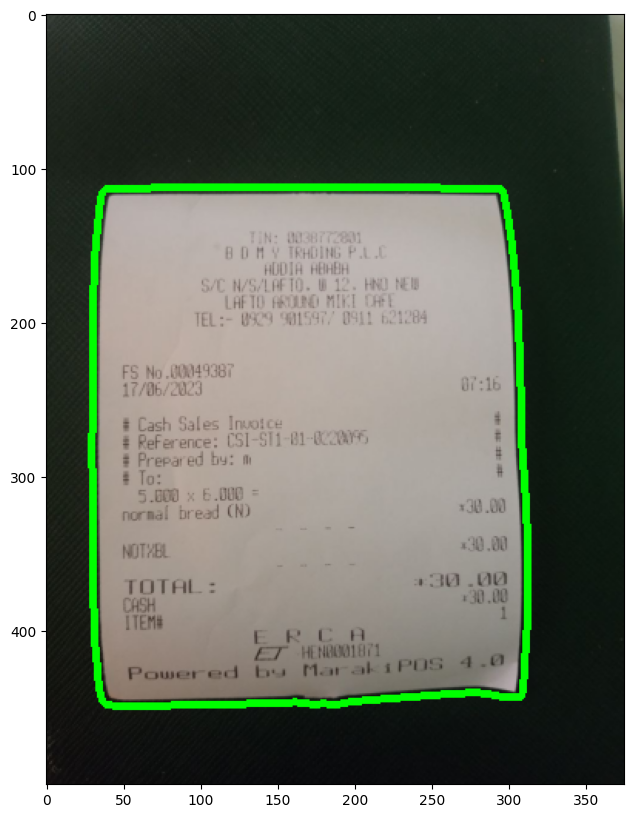

In [14]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [17]:
receipt_contour = get_receipt_contour(largest_contours)

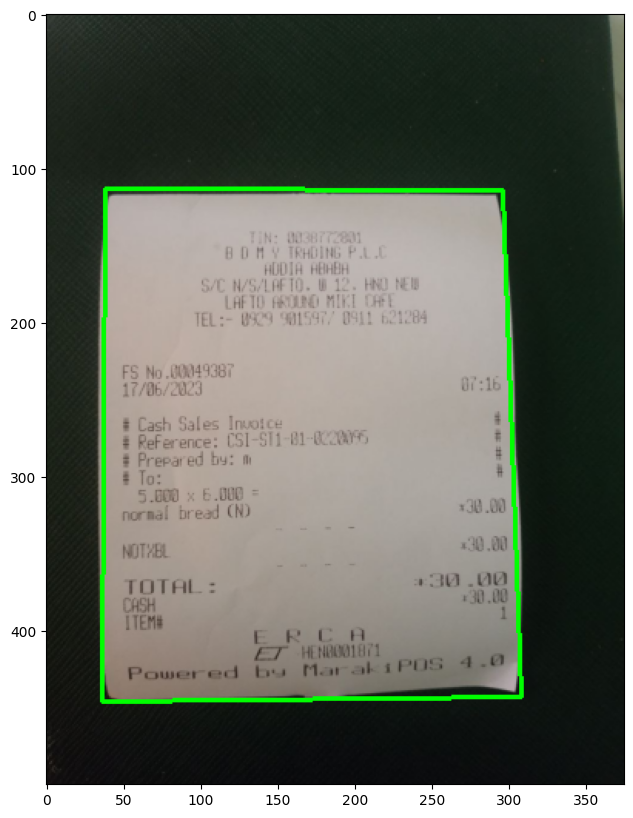

In [18]:
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

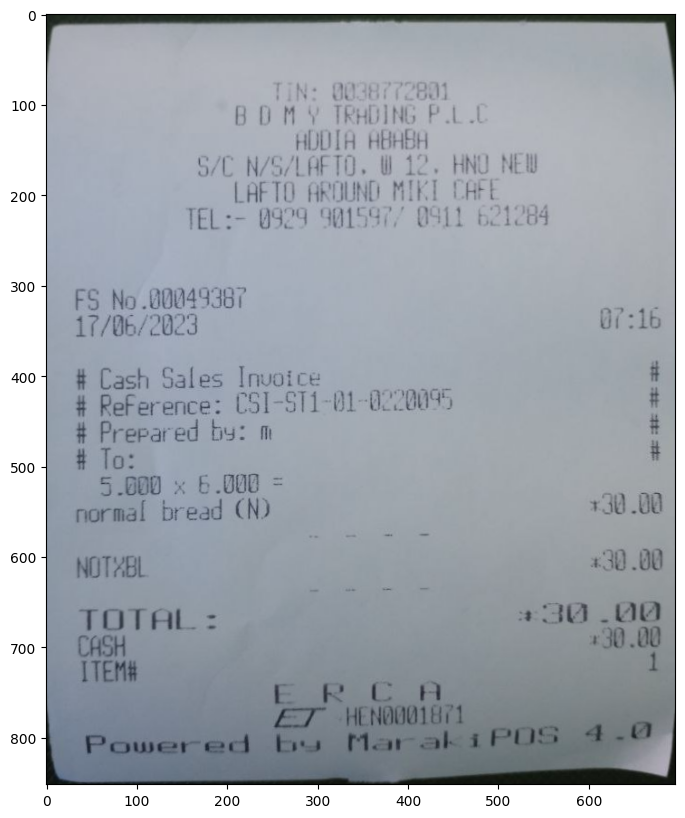

In [19]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

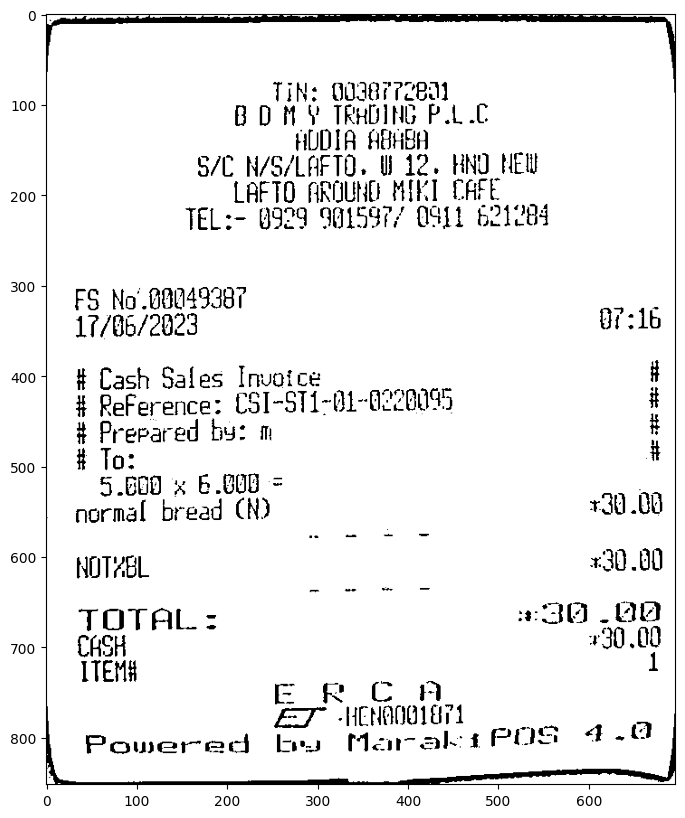

In [20]:
result = bw_scanner(scanned)
plot_gray(result)

C:\Users\Bekalu\AppData\Local\Temp\ipykernel_16692\2229850925.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


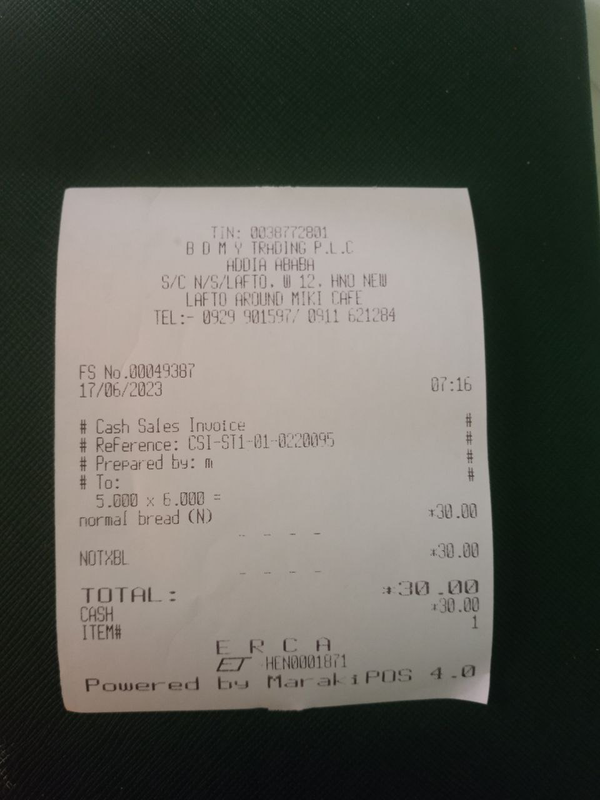

In [21]:
file_name = "C:\\Users\\Bekalu\\Desktop\\seleda\\bill9.jpg"

img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [24]:
#Save image locally
output = Image.fromarray(result)
output.save('result.png')

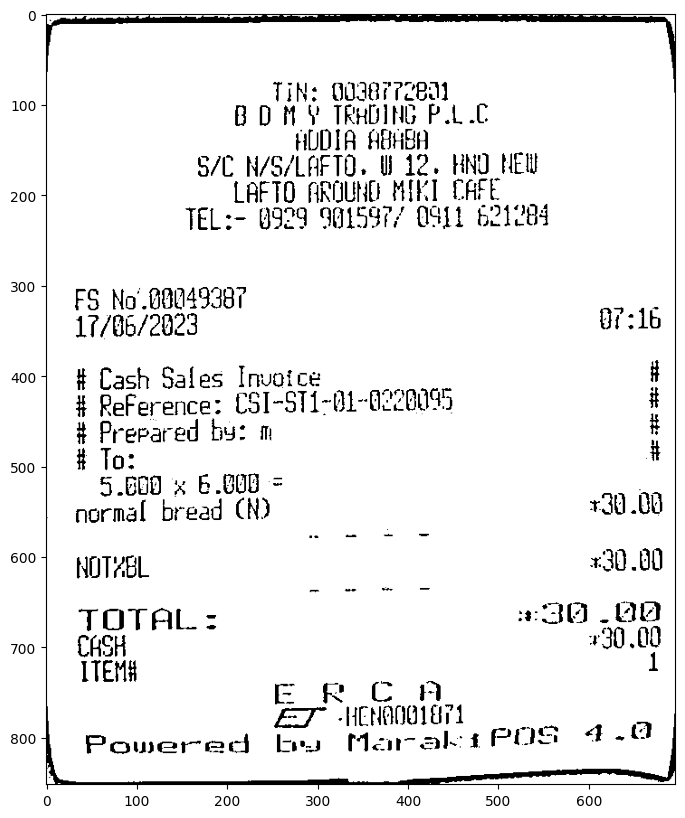

In [25]:
img
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

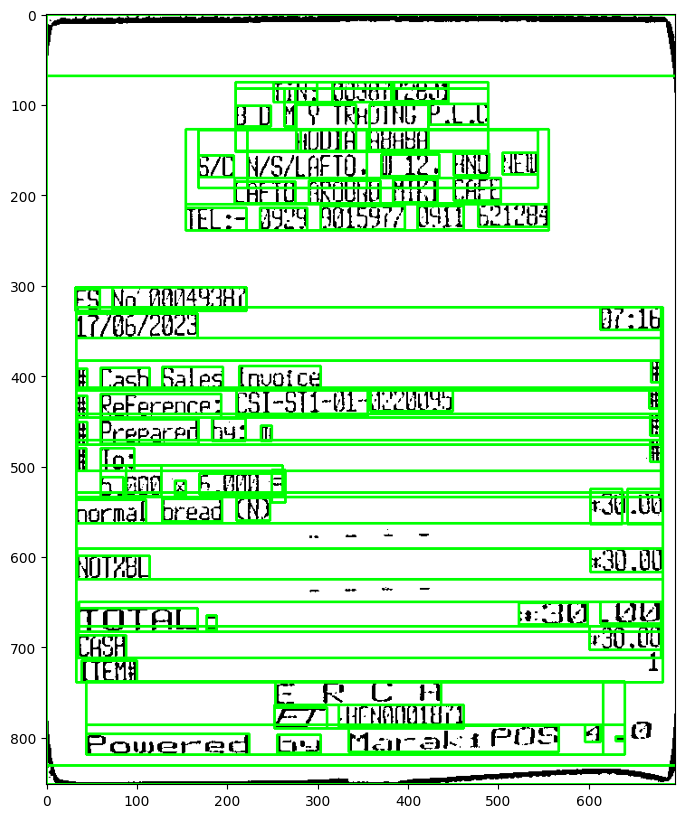

In [26]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [27]:
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(image, config=custom_config)
print(extracted_text)

} TIN: Q0Q8??CB01
BO MY TRHDING PLC
HUDIA ABHEA
S/C N/S/LAFTO. W 12. HNO NEM
LAFTO AROUNO MIRT CARE
TEL:- 8929 9O1597/ OS11 621084
F§ No'.08049387 .
17/86/2023 87:16
# Cash Sales Invoice #
# Reference: CSI-ST1-O1- 0220095 #
# Prepared bu: m #
# To: #
5.600 x 6.000 =
normal bread CN) +290 ..00
NOTABL +30 .00
TOTAL =: 230 48
CASH +3000
— TTEMH 1
ERCA
AT -ENANQ1871 .
Powered Eye MerakiPos 4 -a



In [40]:
#Lines to excluse on the receipt
exclusion_list = ["bank", "total", "promo", "vat", "change", "recyclable"]

#Words to ommit
remove_list = ["vit", "etc","NOTABL"]

In [41]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

["F§ No'.08049387 .", '5.600 x 6.000 =', 'normal bread CN) +290 ..00', 'NOTABL +30 .00']


In [42]:
#Apply exclusion list
food_item = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        food_item.append(eachLine)
print(food_item)

["F§ No'.08049387 .", '5.600 x 6.000 =', 'normal bread CN) +290 ..00', 'NOTABL +30 .00']


In [43]:
#Word ommit
new_food_item_list = []
for item in food_item:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_food_item_list.append(item)
print(new_food_item_list)

["F§ No'.08049387 .", '5.600 x 6.000 =', 'normal bread CN) +290 ..00', ' +30 .00']


In [44]:
#Food item cost regex
food_item_cost = []
for line in new_food_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            food_item_cost.append(possibleCost)
print(new_food_item_list)

["F§ No'.08049387 .", '5.600 x 6.000 =', 'normal bread CN) +290 ..00', ' +30 .00']


In [45]:
#Remove cost price from food item
count = 0;
only_food_items = []
for item in new_food_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
            
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_food_items.append(only_alpha)
print(only_food_items)

['No', '', 'normal bread CN', '']


In [46]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
food = []
for item in only_food_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    food.append(res)
print(food)

['', '', 'normal bread', '']


In [47]:
#Taulate Food Item and Cost
t = PrettyTable(['Food Item', 'Cost'])
for counter in range (0,len(food)):
    t.add_row([food[counter], food_item_cost[counter]])
print(t)

+--------------+-----------+
|  Food Item   |    Cost   |
+--------------+-----------+
|              | .08049387 |
|              |   5.600   |
| normal bread |   6.000   |
|              |    .00    |
+--------------+-----------+
